In [1]:
import torchvision.transforms as T
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np
import copy
from collections import Counter
import track
import pickle
from util import save_as_json, save_counts_json
from track import Track
import time
from tqdm import tqdm


from sklearn.cluster import DBSCAN

# path to datatset
mnist = '/media/andrew/MLData/mnist/'
sprites = '../../data/sprites-MOT/sprite/'

torch.Size([96, 20, 3, 128, 128])


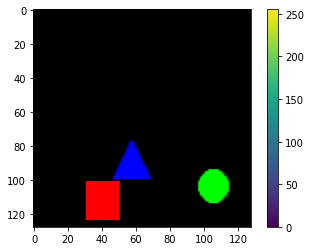

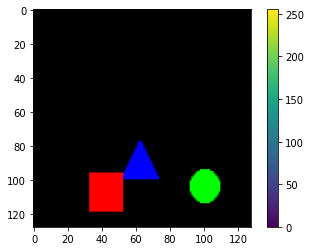

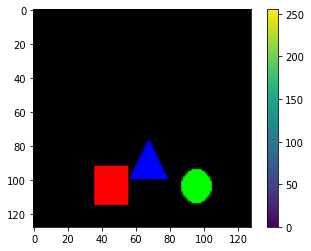

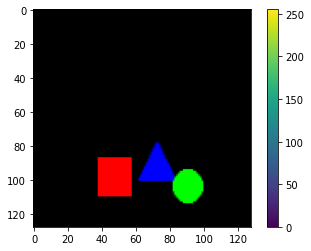

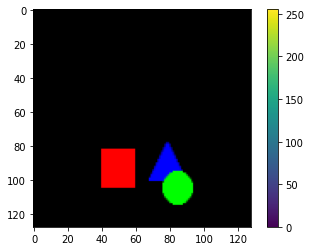

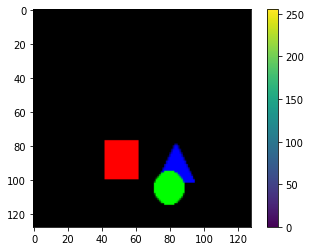

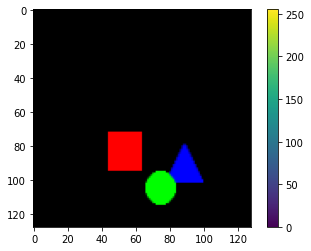

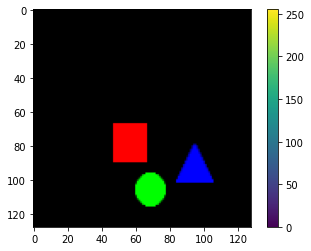

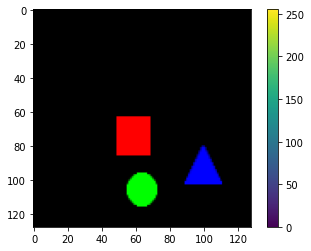

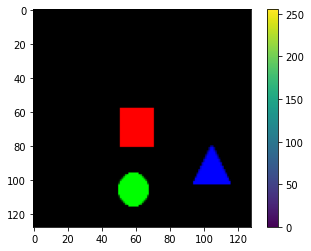

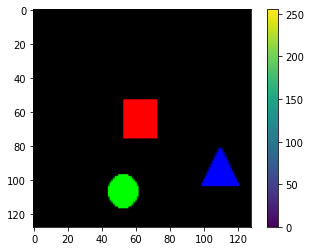

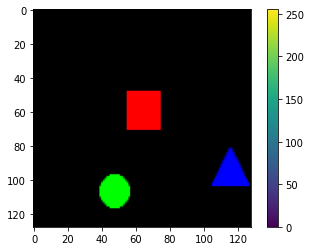

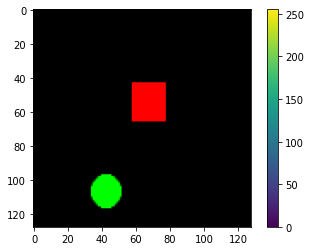

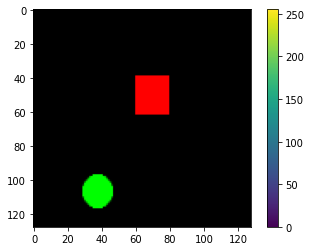

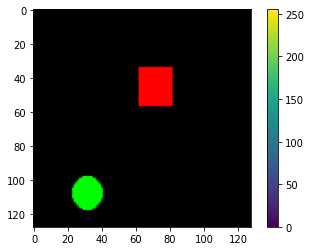

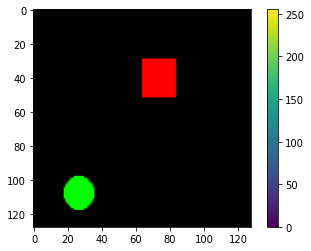

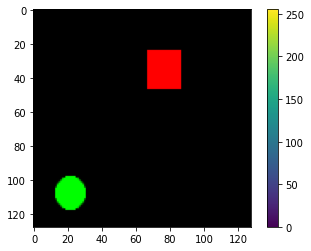

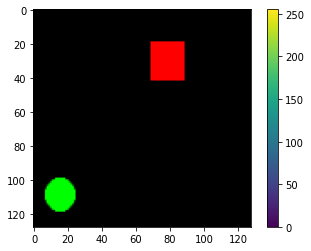

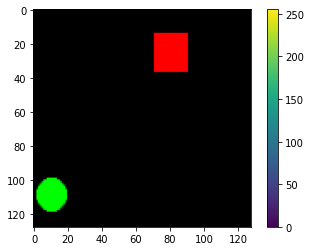

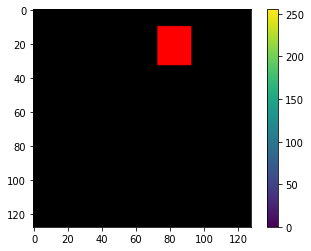

In [3]:
full_train_c = torch.IntTensor(96, 20, 3, 128, 128)
for fnum in range(0,96):
    with open(sprites + 'pt/input/train_{}.pt'.format(fnum), 'rb') as f:
        img = torch.load(f)
        img = img.type(torch.int)
        full_train_c[fnum, ...] = img[0, ...]
    
print(full_train_c.shape)
with open('../../data/sprites-MOT/sprite/pt/full_train_c.pt', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    np.save(f, full_train_c)

for i in range(0, 20):
    plt.figure()
    rgb = full_train_c[11,i, ...].detach().numpy()
    plt.imshow(rgb.transpose((1,2,0)))
    plt.colorbar()
    plt.show()


In [5]:
print(full_train_c.shape)

torch.Size([96, 20, 3, 128, 128])


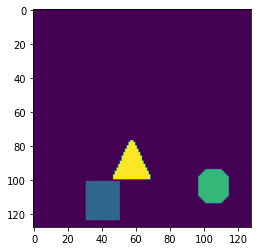

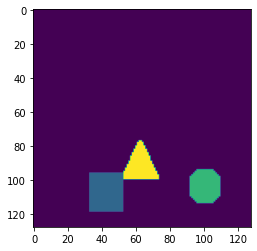

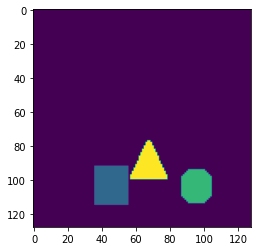

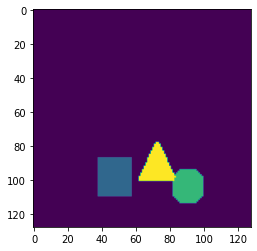

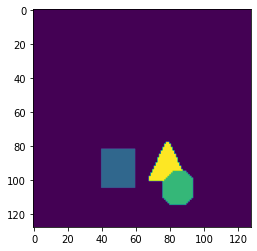

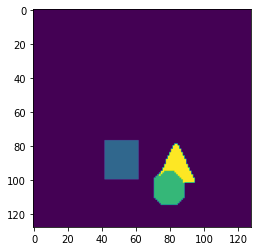

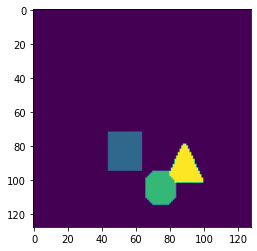

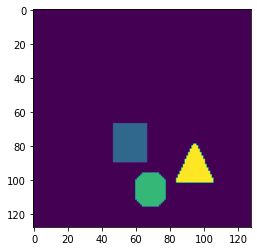

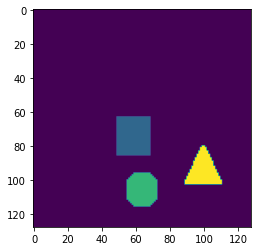

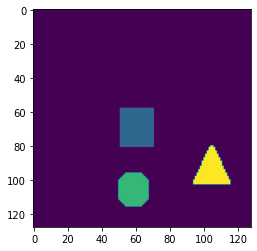

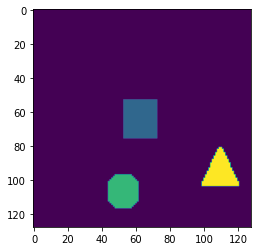

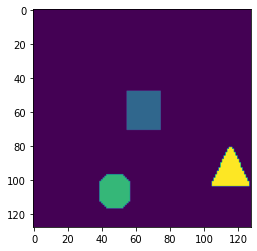

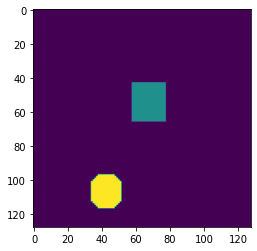

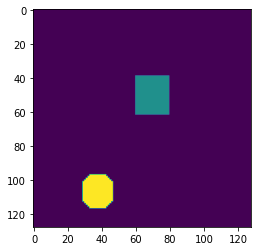

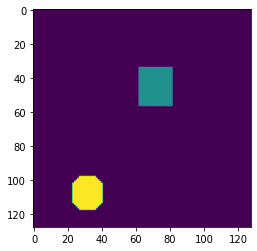

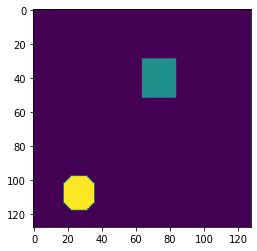

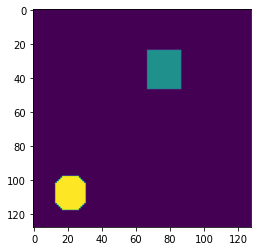

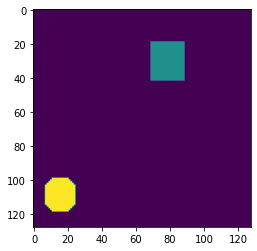

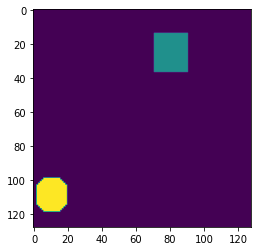

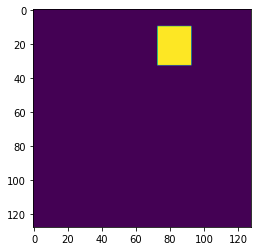

In [6]:
normed_train = torch.IntTensor(96, 20, 1, 128, 128)
for batch_num in range(0,96):

    for time in range(0, 20):
        normed = torch.zeros((128, 128))
        r = torch.nonzero(full_train_c[batch_num,time,0, ...])
        normed[r[:,0], r[:,1]] = 1
        g = torch.nonzero(full_train_c[batch_num,time,1, ...])
        normed[g[:,0], g[:,1]] = 2
        b = torch.nonzero(full_train_c[batch_num,time,2, ...])
        normed[b[:,0], b[:,1]] = 3
        normed_train[batch_num,time,0,...] = normed

for i in range(0, 20):
    # print(torch.unique(normed))
    plt.figure()
    plt.imshow(normed_train[11,i,0,...].detach().numpy())
    plt.show()

normed_train = normed_train.numpy()


(96, 20, 1, 128, 128) <class 'numpy.ndarray'>
(1, 1920, 1, 128, 128)


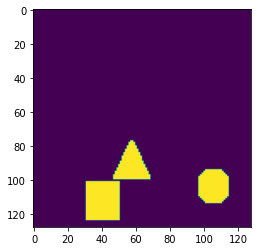

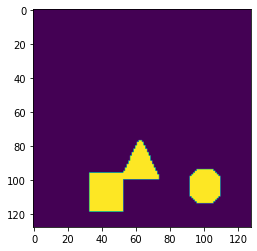

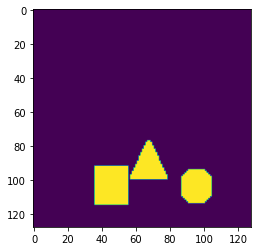

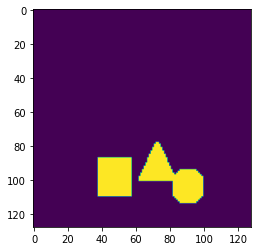

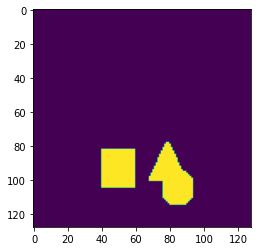

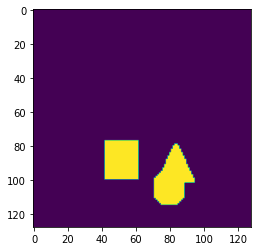

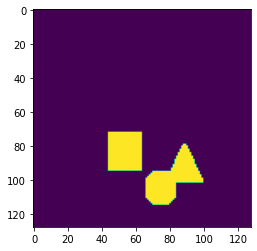

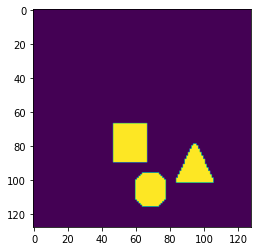

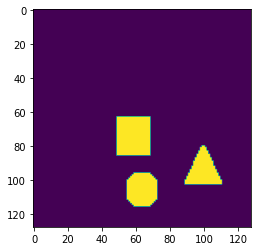

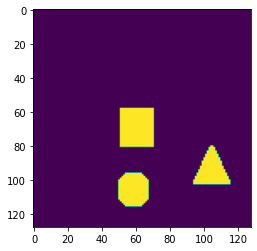

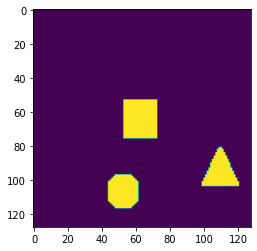

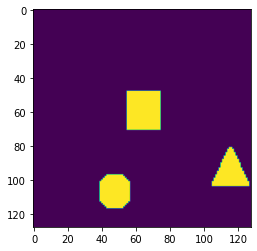

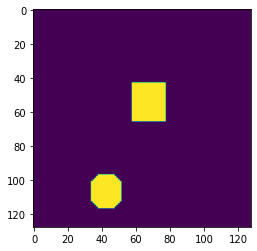

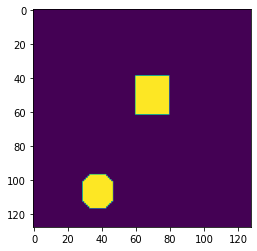

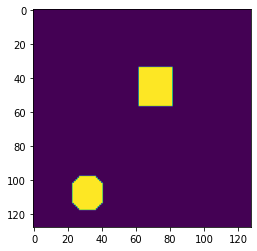

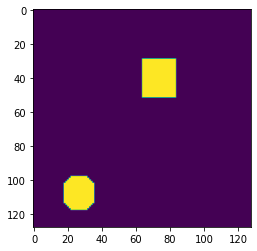

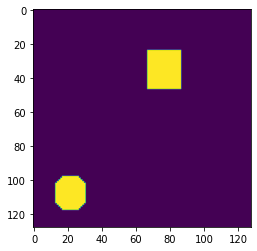

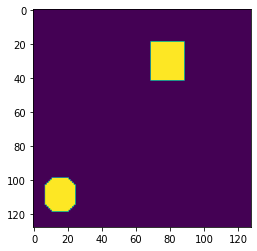

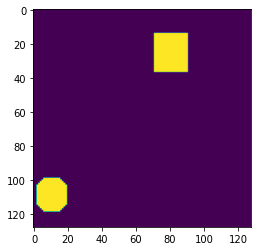

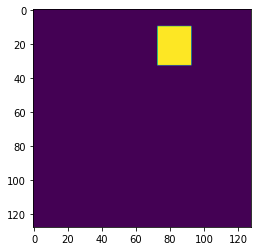

In [7]:
print(normed_train.shape, type(normed_train))

normed_train = np.reshape(normed_train, (1,1920,1,128,128))


print(normed_train.shape)


full_train = np.clip(normed_train, 0, 1)
for i in range(220, 240):
    # print(torch.unique(normed))
    plt.figure()
    plt.imshow(full_train[0,i,0,...])
    plt.show()

with open('../../data/sprites-MOT/sprite/pt/full_train.npy', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    np.save(f, full_train)



In [11]:
counts = {}
for frame in range(0,1920):
    timeSlice = normed_train[0,frame,0,...]
    uniqueClusters = np.unique(timeSlice)
    # subtract 1, dont count 0
    counts[frame] = len(uniqueClusters) - 1

save_counts_json(counts)

In [9]:
def calc_centroid(arr):
    '''
        Calculate centrioid of a point cluster
    '''
    length = arr.shape[0]
    sumX = np.sum(arr[:, 0])
    sumY = np.sum(arr[:, 1])
    return [sumX/length, sumY/length]

In [10]:
'''
    Need to create a ground truth for tracking we will use segmentation labels
    to id the clusters in the first frame and use this as our ground truth.

    create tracks for the rest of the frames but only init location data

    Output: Will populate self.tracks with track objects of each cluster
'''
frames = [f for f in range(0, 1920)]
tracks = {key: [] for key in frames}  # contains tracks for each frame

for t in tqdm(range(0, 1920)):
    # get frame
    timeSlice = normed_train[0, t, 0, ...]
    # find unique clusters
    uniqueClusters = np.unique(timeSlice)
    # create an track object for each clsuter and add to tracks list
    for clusterID in uniqueClusters:
        if clusterID == 0:
            continue

        locations = np.argwhere(timeSlice == clusterID)
        if t == 1:
            newTrack = Track(locs=locations, 
                                id=clusterID, 
                                centroid=calc_centroid(locations), 
                                state='active', 
                                origin='init')
        else:
            newTrack = Track(locs=locations, 
                                id=None, 
                                centroid=calc_centroid(locations), 
                                state=None, 
                                origin=None)

        tracks[t].append(copy.deepcopy(newTrack))

print('Total tracks: ', len(tracks))
with open('../../data/sprites-MOT/sprite/pt/tracks_sprite.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(tracks, f, pickle.HIGHEST_PROTOCOL)


100%|██████████| 1920/1920 [00:00<00:00, 2059.02it/s]
Total tracks:  1920


In [12]:

full_train_c = np.reshape(full_train_c, (1,1920,3,128,128))
print(full_train_c.shape)
for t in tqdm(range(0, 1920)): 
    img = transforms.ToPILImage()(full_train_c[0,t, ...].type(torch.ByteTensor))
    img.save('../../data/sprites-MOT/sprite_imgs/img{}.png'.format(t))
    # print(img)
    # img.show()

100%|██████████| 1920/1920 [00:03<00:00, 542.17it/s]


In [20]:
videodims = (128,128)
fourcc = cv2.VideoWriter_fourcc(*"MJPG")    
video = cv2.VideoWriter('../../data/sprites.avi',fourcc, 15,videodims)
#draw stuff that goes on every frame here
for t in tqdm(range(0, 1920)):
    imtemp = Image.open('../../data/sprites-MOT/sprite_imgs/img{}.png'.format(t))
    # draw frame specific stuff here.
    video.write(cv2.cvtColor(np.array(imtemp), cv2.COLOR_RGB2BGR ))

video.release()
# Closes all the frames 
cv2.destroyAllWindows() 

100%|██████████| 1920/1920 [00:01<00:00, 1288.50it/s]


In [15]:
with open('../../data/sprites-MOT/sprite/pt/labeled_tracks_sprites.pickle', 'rb') as f:
    labeled_tracks_sprites = pickle.load(f)

In [18]:
videodims = (128,128)
fourcc = cv2.VideoWriter_fourcc(*"MJPG")    
video = cv2.VideoWriter('../../data/labeled_sprites.avi',fourcc, 15,videodims)
#draw stuff that goes on every frame here
for t in tqdm(range(0, 1920)):
    original = Image.open('../../data/sprites-MOT/sprite_imgs/img{}.png'.format(t))
    labeled = ImageDraw.Draw(original)
    for track in labeled_tracks_sprites[t]:
        labeled.text((track.centroid[1], track.centroid[0]), "{}".format(track.id))
    original.save('../../data/sprites-MOT/sprite_imgs/labeled_img{}.png'.format(t))
    # draw frame specific stuff here.
    video.write(cv2.cvtColor(np.array(original), cv2.COLOR_RGB2BGR ))

video.release()
# Closes all the frames 
cv2.destroyAllWindows() 

100%|██████████| 1920/1920 [00:04<00:00, 456.36it/s]
